C:\Users\hegoi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\hegoi\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0/10000 | D Loss: 0.7983, Acc: 0.2500 | G Loss: 0.7532
Epoch 1000/10000 | D Loss: 0.7599, Acc: 0.4999 | G Loss: 0.6944
Epoch 2000/10000 | D Loss: 0.7600, Acc: 0.4999 | G Loss: 0.6939
Epoch 3000/10000 | D Loss: 0.7603, Acc: 0.5000 | G Loss: 0.6937
Epoch 4000/10000 | D Loss: 0.7604, Acc: 0.5000 | G Loss: 0.6936
Epoch 5000/10000 | D Loss: 0.7604, Acc: 0.5000 | G Loss: 0.6936
Epoch 6000/10000 | D Loss: 0.7604, Acc: 0.5000 | G Loss: 0.6935
Epoch 7000/10000 | D Loss: 0.7605, Acc: 0.5000 | G Loss: 0.6935
Epoch 8000/10000 | D Loss: 0.7605, Acc: 0.5000 | G Loss: 0.6935
Epoch 9000/10000 | D Loss: 0.7605, Acc: 0.5000 | G Loss: 0.6935
Epoch 9999/10000 | D Loss: 0.7605, Acc: 0.5000 | G Loss: 0.6935
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


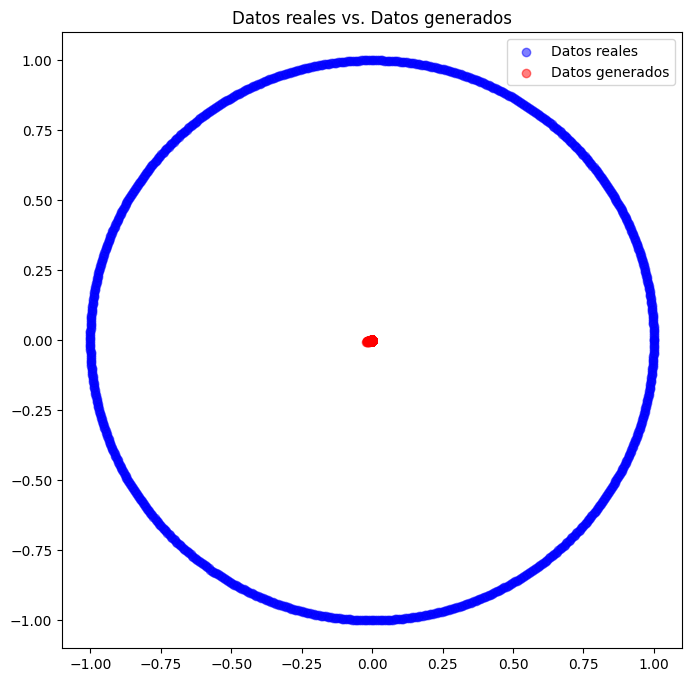

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Parámetros básicos
latent_dim = 2  # Dimensión del espacio latente
num_samples = 1000  # Número de muestras reales a generar para el dataset

# Crear datos reales simples (distribución de puntos en un círculo)
def generate_real_data(num_samples):
    angles = np.linspace(0, 2 * np.pi, num_samples)
    x = np.cos(angles)
    y = np.sin(angles)
    return np.stack([x, y], axis=1)

real_data = generate_real_data(num_samples)

# Construir el generador
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(16, activation="relu", input_dim=latent_dim),
        layers.Dense(32, activation="relu"),
        layers.Dense(2, activation="linear")  # Salida de 2 dimensiones (x, y)
    ])
    return model

# Construir el discriminador
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Dense(32, activation="relu", input_dim=2),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid")  # Salida binaria (real o falso)
    ])
    return model

# Instanciar generador y discriminador
generator = build_generator()
discriminator = build_discriminator()

# Compilar discriminador
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                      loss="binary_crossentropy", metrics=["accuracy"])

# Combinar generador y discriminador para entrenar la GAN
# Congelamos el discriminador cuando entrenamos la GAN
discriminator.trainable = False

gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="binary_crossentropy")

# Función de entrenamiento
def train_gan(generator, discriminator, gan, real_data, epochs=10000, batch_size=64):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Generar datos reales y etiquetas
        idx = np.random.randint(0, real_data.shape[0], half_batch)
        real_samples = real_data[idx]
        real_labels = np.ones((half_batch, 1))

        # Generar datos falsos y etiquetas
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_samples = generator.predict(noise, verbose=0)
        fake_labels = np.zeros((half_batch, 1))

        # Entrenar el discriminador
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Entrenar la GAN (a través del generador)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Mostrar progreso
        if epoch % 1000 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss[0]:.4f}, Acc: {d_loss[1]:.4f} | G Loss: {g_loss:.4f}")

# Entrenar la GAN
train_gan(generator, discriminator, gan, real_data)

# Generar puntos sintéticos después del entrenamiento
noise = np.random.normal(0, 1, (1000, latent_dim))
generated_data = generator.predict(noise)

# Visualizar datos reales y generados
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(real_data[:, 0], real_data[:, 1], color='blue', label='Datos reales', alpha=0.5)
plt.scatter(generated_data[:, 0], generated_data[:, 1], color='red', label='Datos generados', alpha=0.5)
plt.legend()
plt.title("Datos reales vs. Datos generados")
plt.show()
